## GPU Acceleration and Batch Processing

### 1. Batched Processing
- On a Solver class, when 'is_batched' is True, the first axis will be regarded as
 the batch dimension.

In [1]:
import numpy as np
from fringe.solvers.AngularSpectrum import AngularSpectrumSolver as AsSolver
from matplotlib import pyplot as plt

#### 1D Arrays
- Note that for 1-dimensional short arrays, Numpy is way more performant than TensorFlow.

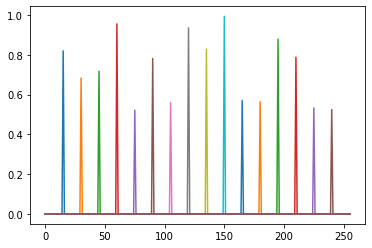

D:\LocalSoftwareProjects\Fringe\fringe\backend\Numpy.py:41: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return input_[slc]


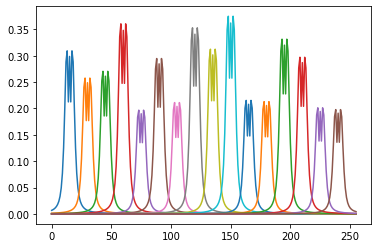

In [3]:
# define a 1D object
obj = np.zeros((16, 256)).astype('float32') # obj: (batch_size, data)
for i in range(obj.shape[0]):
    j = int(i * (obj.shape[1] - 16)/obj.shape[0] + 16 - 1)
    obj[i, j] = 0.5 + np.random.rand(1) * 0.5
    plt.plot(obj[i])

plt.show()
obj = (obj + 0j).astype('complex64')

# Initialize Angular Spectrum Solver
solver = AsSolver(shape=obj.shape, dr=1, is_batched=True, padding="same",
                  pad_fill_value=0, backend="Numpy")

# Propagate with a given set of k (wavenumber) and z (axial distance)
rec = solver.solve(input_=obj, k=2 * np.pi/500e-3, z=-20)
amp = np.abs(rec) # Must get squared to simulate intensity acquisition
phase = np.angle(rec) # Phase unwrapping should be applied at this stage

ax = plt.subplot(1, 1, 1)
for i in range(obj.shape[0]):
    ax.plot(amp[i])
plt.show()

### 2. GPU Acceleration

In [4]:
import tensorflow as tf
import time

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    device = "/gpu:0"
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    device = "/cpu:0"

print("{device} is set-up and ready.".format(device=device))

1 Physical GPUs, 1 Logical GPUs
/gpu:0 is set-up and ready.


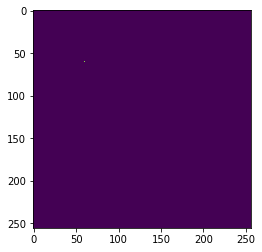

Elapsed time:  7.2989342212677


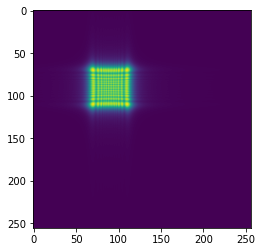

In [10]:
# define a 2D object
obj = np.zeros((16, 256, 256)).astype('float32') # obj: (batch_size, data)
for i in range(obj.shape[0]):
    j = int(i * (obj.shape[1] - 16)/obj.shape[0] + 16 - 1)
    obj[i, j, j] = 0.5 + np.random.rand(1) * 0.5

plt.imshow(obj[3])
plt.show()

obj = (obj + 0j).astype('complex64')

# Initialize Angular Spectrum Solver
solver = AsSolver(shape=obj.shape, dr=1, is_batched=True, padding="same",
                  pad_fill_value=0, backend="TensorFlow")

obj = tf.convert_to_tensor(obj)

# Test on GPU: 1000 propagations
t = time.time()
with tf.device(device):
    for i in range(1000):
        rec = solver.solve(input_=obj, k=2 * np.pi/500e-3, z=-i * 0.1)
print("Elapsed time: ", time.time() - t)

plt.imshow(np.abs(rec[5]))
plt.show()
